# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [10]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [11]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [12]:
df.y.value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below:

Due to domestic competition and current financial constrains, there is immense pressure on Portugese banks to increase financial assets in order to leverage domestic economic input. To solve this issue, one adopted strategy is to offer attractive long-term deposit applications with high interest rates, particularly by using directed marketing campaigns. The same economic factors apply for cost reduction and time value of money. Thus, there is a need for improvement in efficiency: reduced customer interaction must be done, while mainintaining the same conversion rate (clients subscribing to the deposit). This model intends to highlight the banking customers most likley to respond positivly to bank marketing material. See data exploration and transformation below.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [14]:
#Template for viz by feature for data exploration
def plot_by_feature(feature, rotate=0):
    plt.subplots(figsize=(16,6))
    splot = sns.countplot(data=df, x=feature, hue = 'y')
    plt.xlabel('Accepted Marketing Campaign by ' + feature.capitalize())
    plt.xticks(rotation = 90)
    plt.ylabel(feature.capitalize() + ' Count')
    plt.title('Acceptance of Marketing Campaign by ' + feature.capitalize())
    plt.show()

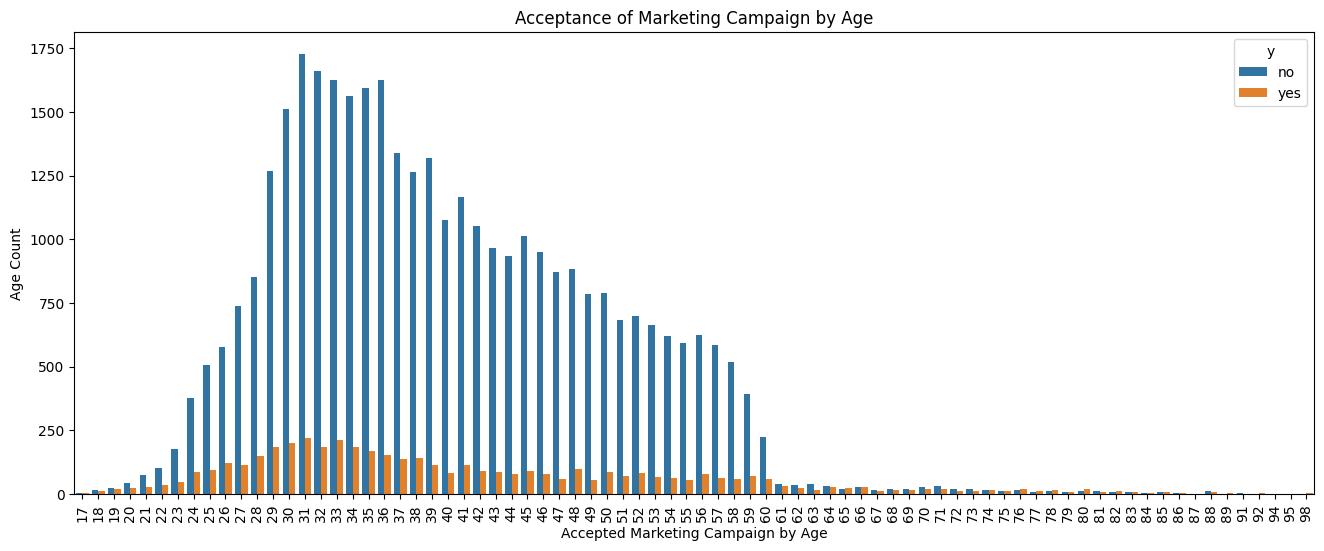

In [15]:
plot_by_feature('age')

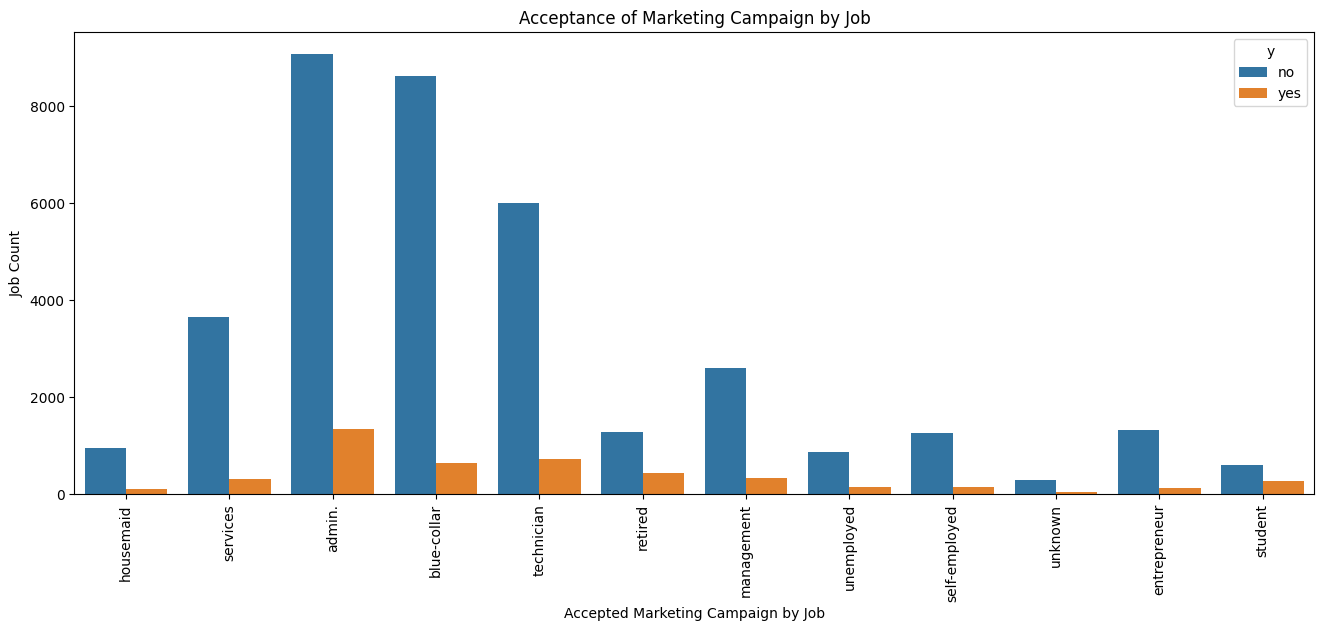

In [16]:
plot_by_feature('job')

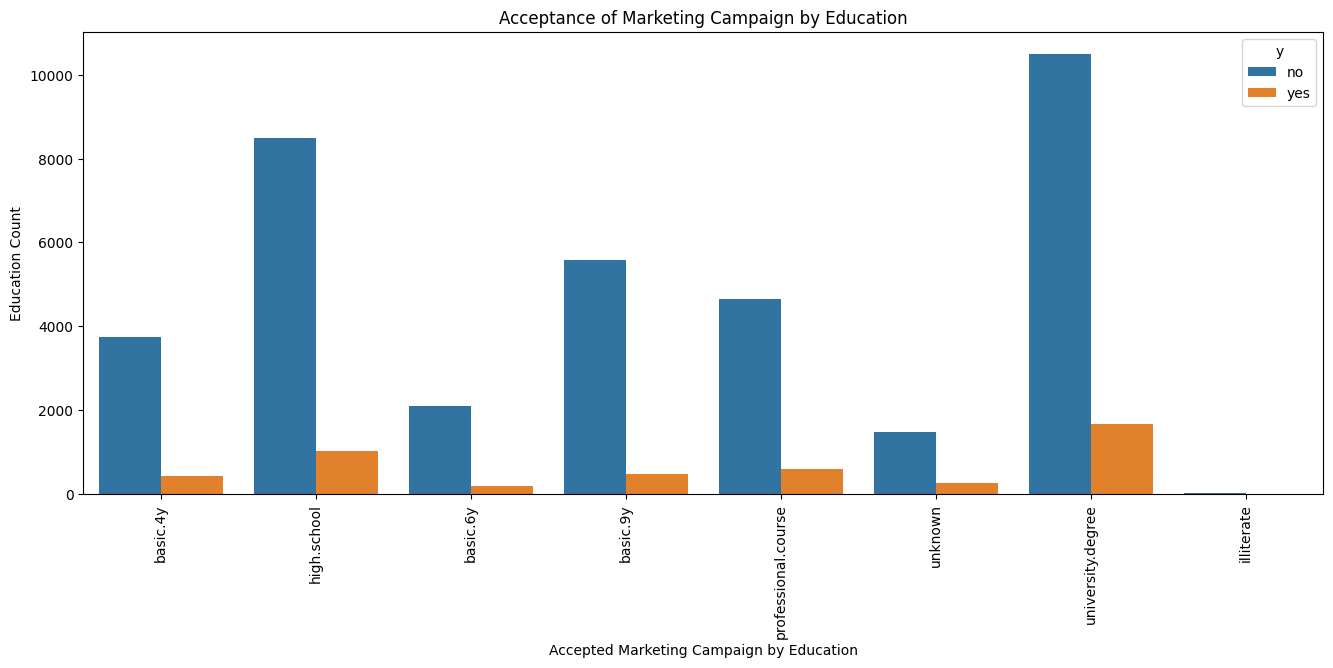

In [17]:
plot_by_feature('education')

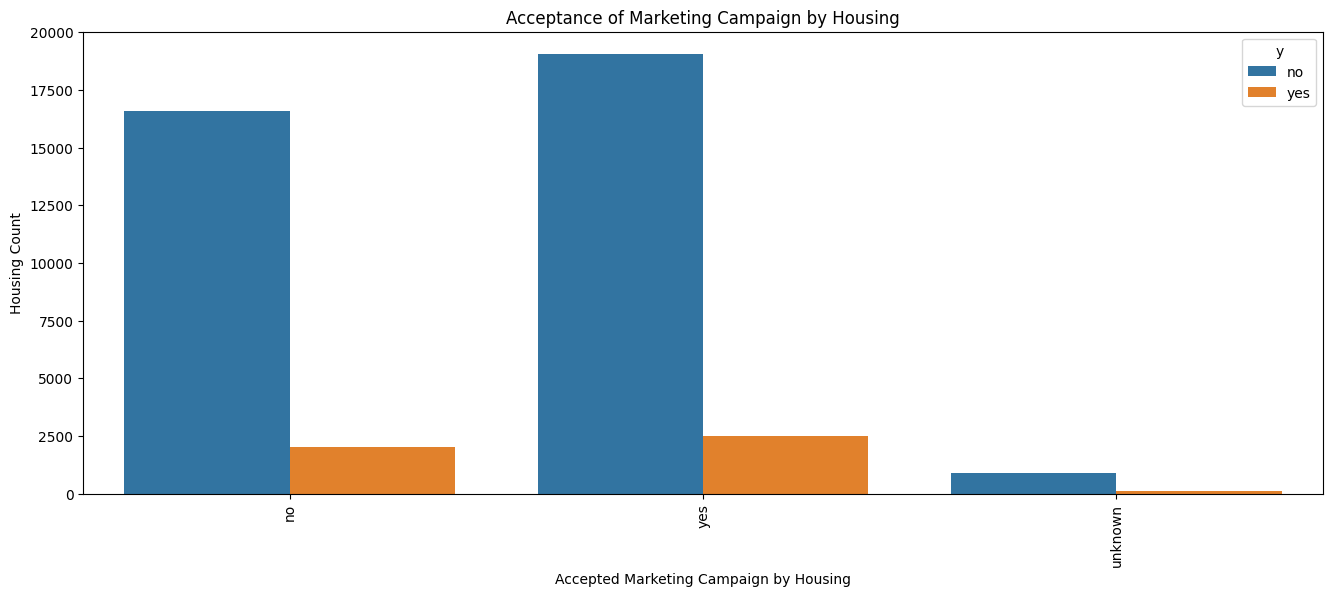

In [18]:
plot_by_feature('housing')

In [19]:
tstart = datetime.now()
print(tstart)

2025-02-04 15:52:51.998495


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [21]:
#Transform string data to numeric values using factorize and mapping
df['job'] = df['job'].factorize()[0]
df['marital'] = df['marital'].factorize()[0]
df['education'] = df['education'].map({'basic.4y':2,'basic.6y':3,'basic.9y':4,'high.school':5,'illiterate':1,
                                           'professional.course':6,'university.degree':7,'unknown':0})
mapping = {'no':1,'yes':2,'unknown':0}
df['default'] = df['default'].map(mapping)
df['housing'] = df['housing'].map(mapping)
df['loan'] = df['loan'].map(mapping)
df['contact'] = df['contact'].map({'cellular':1,'telephone':0})
df['month'] = df['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9,
                                   'oct':10, 'nov':11, 'dec':12})
df['day_of_week'] = df['day_of_week'].map({'mon':1,'tue':2,'wed':3,'thu':4,'fri':5})
df['poutcome'] = df['poutcome'].map({'failure':1,'nonexistent':0,'success':2})
df['y'] = df['y'].map({'no':0, 'yes':1})
df.dropna(inplace = True)

In [22]:
df = df.drop_duplicates()

In [23]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [24]:
#group by factorized and mapped features then group output without target column to see if any features overlap in two classes
df1 = df.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']).size().reset_index()
df1 = df1[df1[0]>1][['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
df1

,age,job,marital,education,default,housing,loan
5,18,11,1,0,1,1,1
6,18,11,1,0,1,2,1
9,18,11,1,2,1,2,1
14,18,11,1,4,1,2,1
15,18,11,1,5,1,1,1
...,...,...,...,...,...,...,...
12971,85,0,0,2,0,1,1
12975,85,5,0,2,1,1,1
12979,85,5,2,2,0,2,1
12993,88,5,2,2,1,2,1


In [25]:
# Find out how many data entries is in the overlapped category to see how good a model could be
# These cannot be correctly classified
print('Overlapped Features Rate:', \
    len(df.merge(df1, on = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'])) / len(df))
print('Overlapped Features Rows:', \
    len(df.merge(df1, on = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'])))

Overlapped Features Rate: 0.47425684864969886
Overlapped Features Rows: 19528


In [26]:
#This indicates that 47% of the data cannot be properly classified - 53% can be in the simple model

In [27]:
# Add more features to have clear boundaries between two distinctive classes
# There are still 237 overlapping features for different classes
df1 = df.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']).size().reset_index()
df1[df1[0]>1]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0
423,23,2,1,6,1,2,1,1,7,3,2,999,0,0,1.4,93.918,-42.7,4.963,5228.1,2
471,23,3,1,4,1,2,1,1,5,1,1,999,0,0,-1.8,92.893,-46.2,1.299,5099.1,2
480,23,3,1,5,1,1,1,1,7,3,1,999,0,0,1.4,93.918,-42.7,4.957,5228.1,2
485,23,3,1,5,1,2,1,1,7,3,1,999,0,0,1.4,93.918,-42.7,4.957,5228.1,2
512,23,6,1,7,1,1,1,1,7,4,2,999,0,0,1.4,93.918,-42.7,4.958,5228.1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38444,63,5,0,5,1,1,1,1,10,3,1,999,0,0,-3.4,92.431,-26.9,0.740,5017.5,2
38962,76,6,0,0,1,1,1,1,9,5,1,999,0,0,-3.4,92.379,-29.8,0.803,5017.5,2
39082,82,5,0,7,1,2,1,1,10,2,1,999,0,0,-3.4,92.431,-26.9,0.744,5017.5,2
39084,82,5,1,2,1,2,1,1,10,4,2,999,0,0,-3.4,92.431,-26.9,0.722,5017.5,2


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

In [29]:
df.y.value_counts(normalize = True)

y
0    0.887337
1    0.112663
Name: proportion, dtype: float64

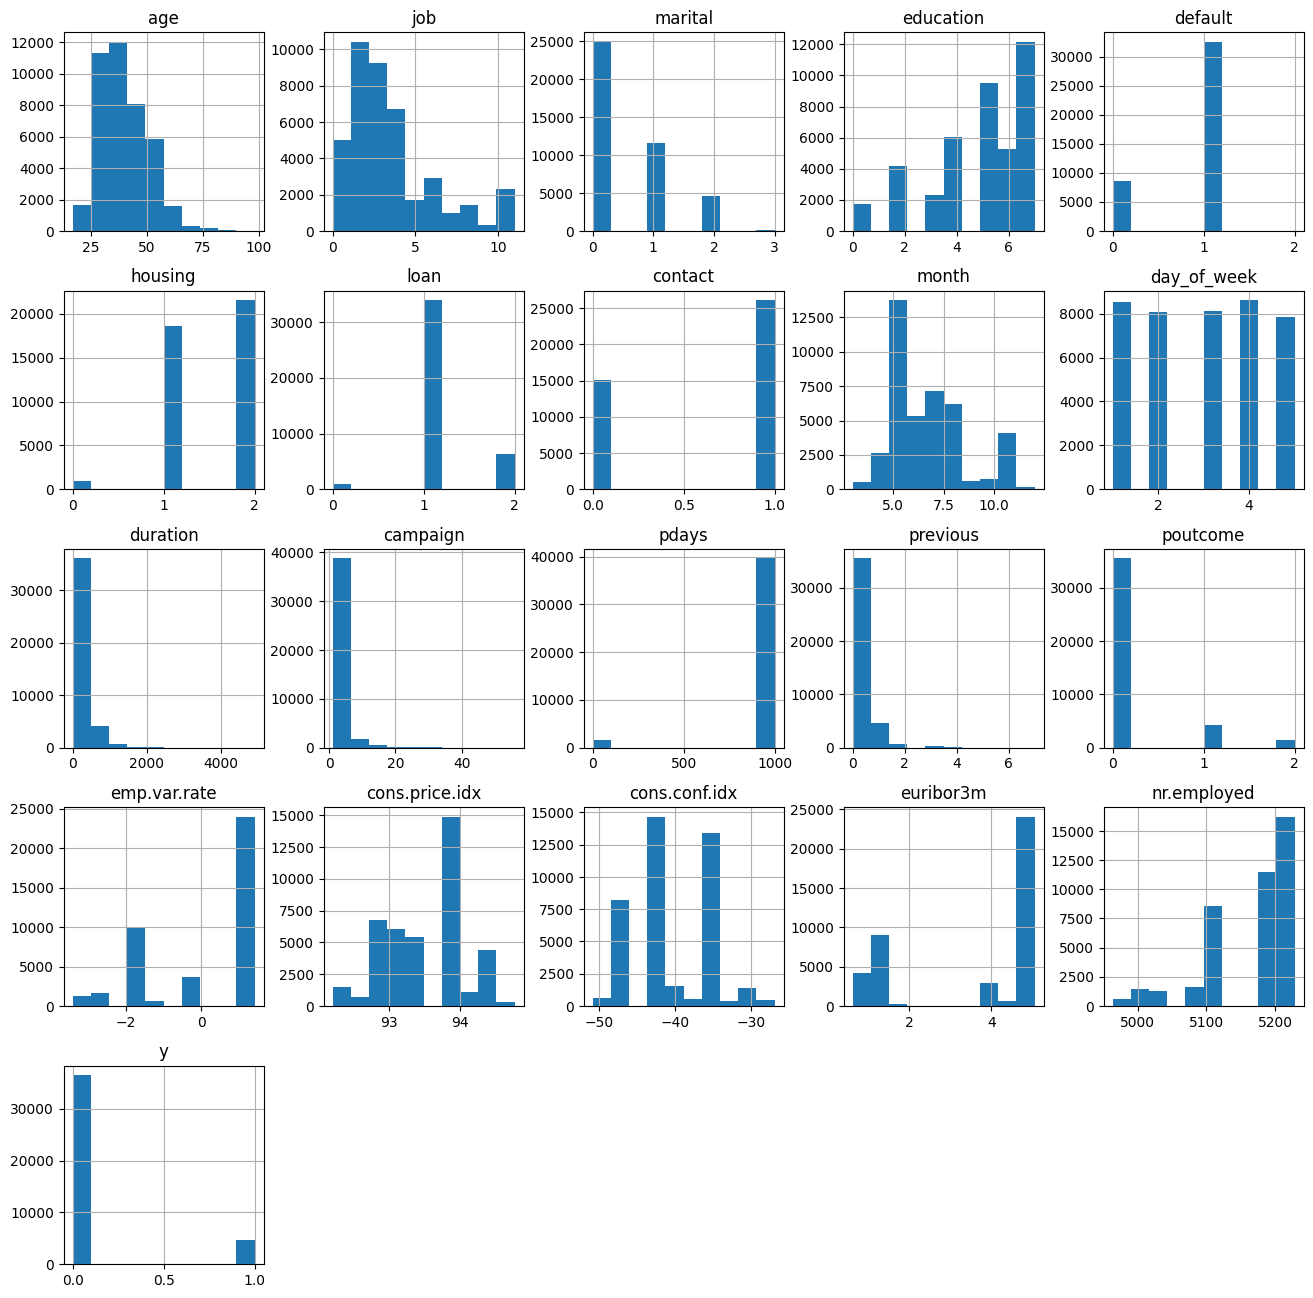

In [30]:
df.hist(figsize = (16, 16))
plt.show()

<Axes: >

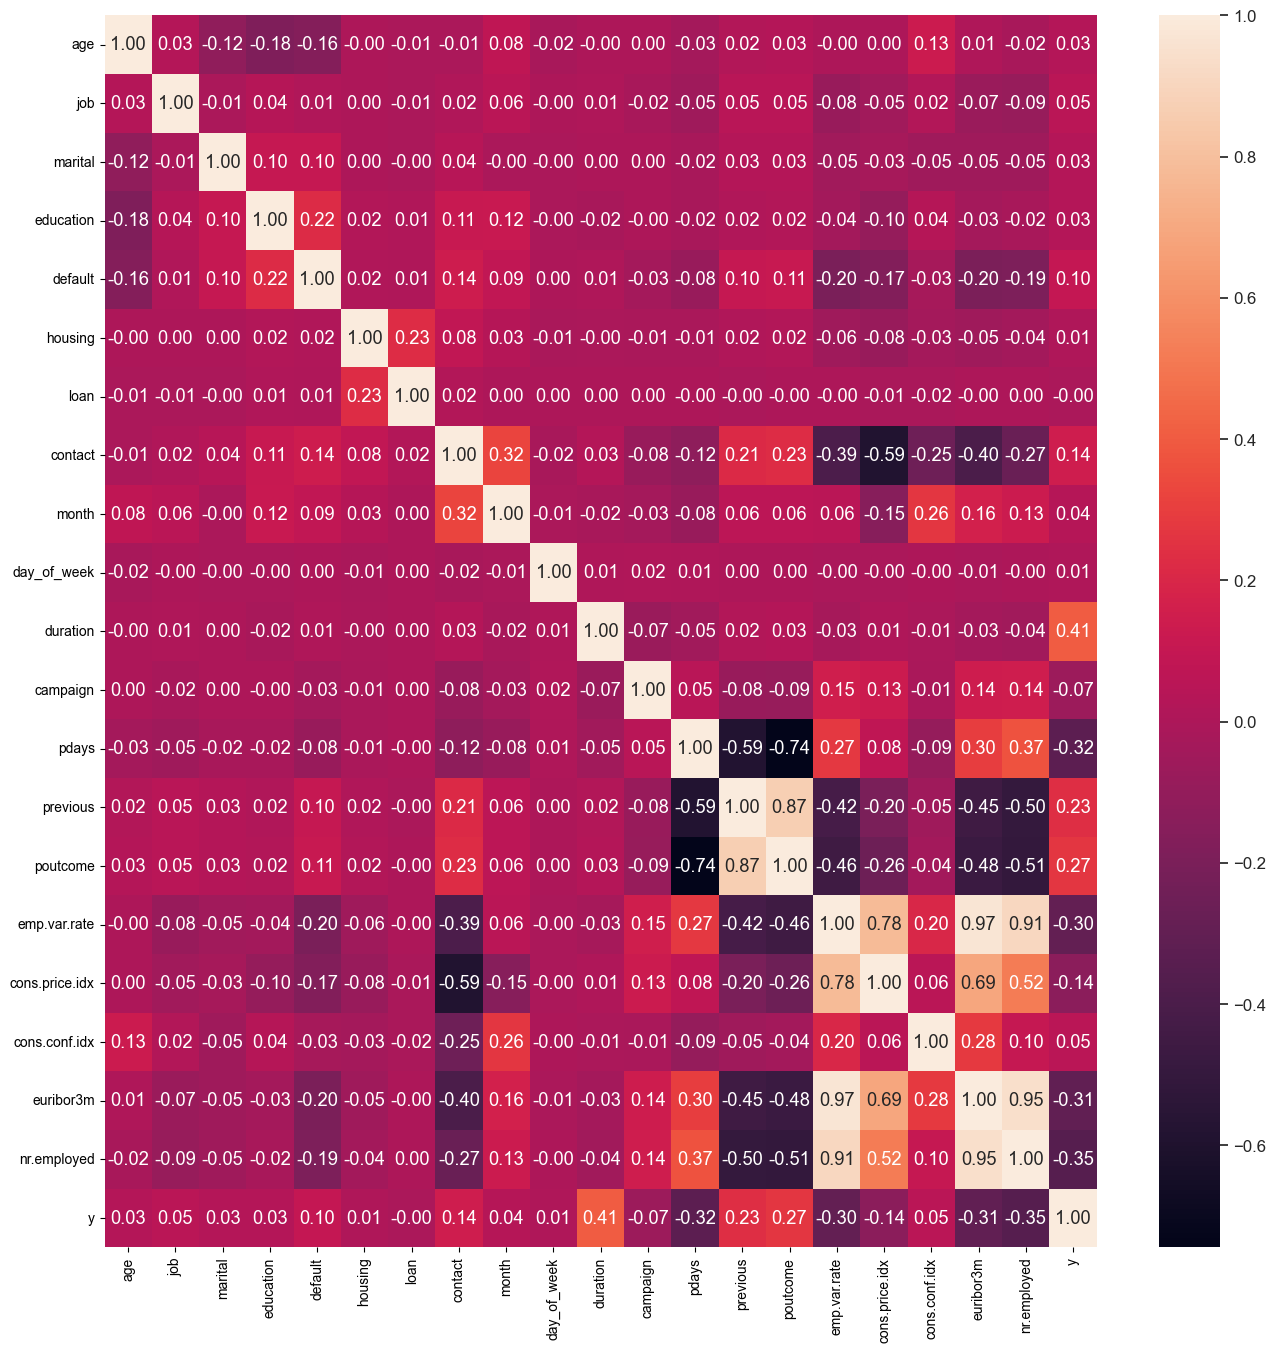

In [31]:
#heatmap
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.1)
sns.heatmap(df.corr(), annot=True, fmt='.2f')

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [32]:
# data was transformed above already, so just copy columns 1-7 and y to X, y
# features from 0 through 6
X, y = df.iloc[:, 0:7], df.y
X

,age,job,marital,education,default,housing,loan
0,56,0,0,2,1,1,1
1,57,1,0,5,0,1,1
2,37,1,0,5,1,2,1
3,40,2,0,3,1,1,1
4,56,1,0,5,1,1,2
...,...,...,...,...,...,...,...
41183,73,5,0,6,1,2,1
41184,46,3,0,6,1,1,1
41185,56,5,0,7,1,2,1
41186,44,4,0,6,1,1,1


In [33]:
# Scale dataframe
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X.shape, X_scaled.shape

((41176, 7), (41176, 7))

In [34]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled

,age,job,marital,education,default,housing,loan
0,1.533143,-1.496903,-0.732848,-1.541920,0.513317,-0.915485,-0.319764
1,1.629107,-1.089456,-0.732848,0.029371,-1.946398,-0.915485,-0.319764
2,-0.290177,-1.089456,-0.732848,0.029371,0.513317,0.916108,-0.319764
3,-0.002284,-0.682010,-0.732848,-1.018156,0.513317,-0.915485,-0.319764
4,1.533143,-1.089456,-0.732848,0.029371,0.513317,-0.915485,2.184342
...,...,...,...,...,...,...,...
41183,3.164534,0.540330,-0.732848,0.553134,0.513317,0.916108,-0.319764
41184,0.573501,-0.274563,-0.732848,0.553134,0.513317,-0.915485,-0.319764
41185,1.533143,0.540330,-0.732848,1.076898,0.513317,0.916108,-0.319764
41186,0.381573,0.132883,-0.732848,0.553134,0.513317,-0.915485,-0.319764


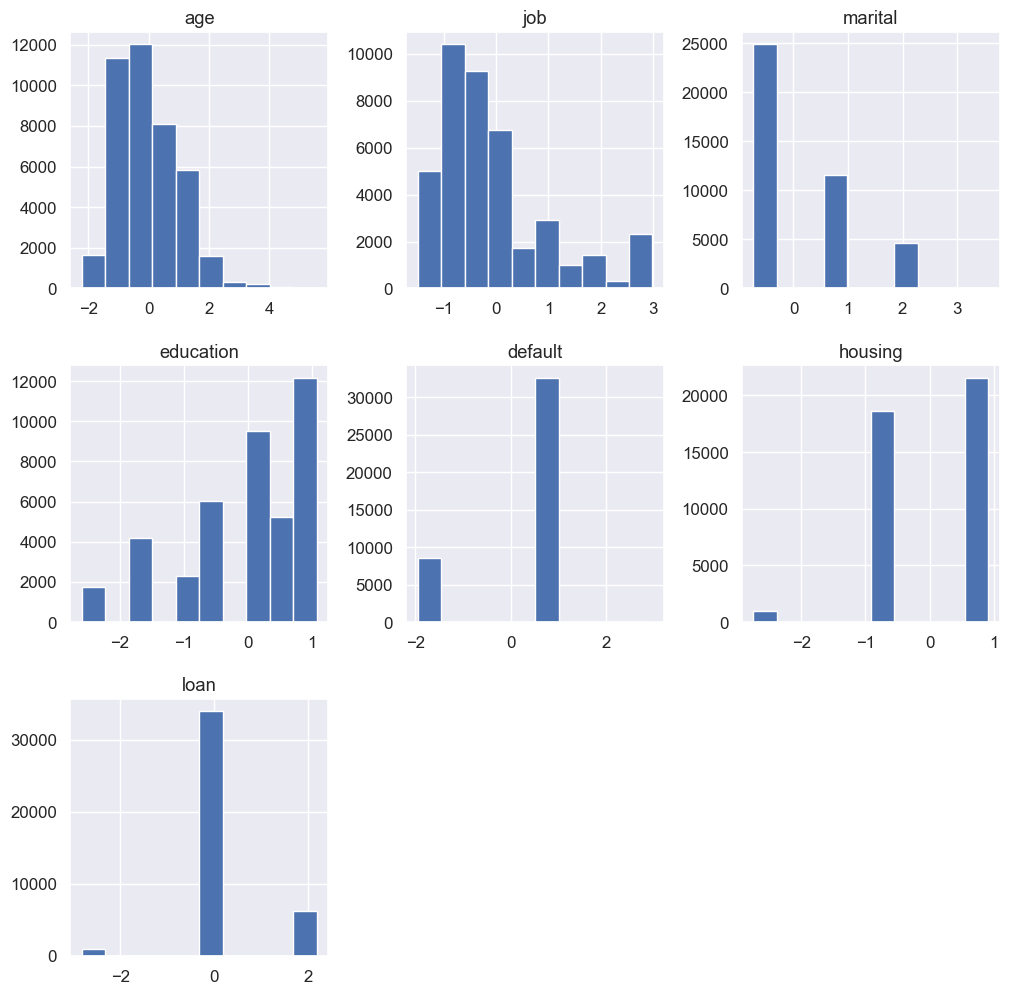

In [35]:
X_scaled.hist(figsize = (12, 12))
plt.show()

<Axes: >

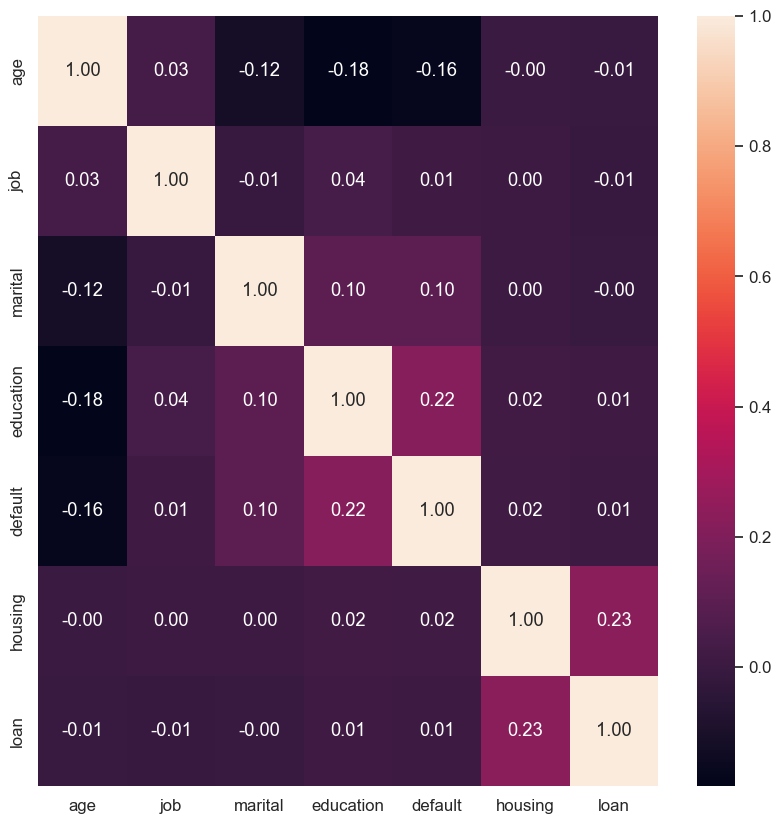

In [36]:
#heatmap
plt.subplots(figsize=(10,10))
sns.set(font_scale=1.1)
sns.heatmap(X_scaled.corr(), annot=True, fmt='.2f')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [37]:
# use scaled dataset to split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 9, test_size = 0.3, stratify = y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [38]:
y.value_counts(normalize = True)

y
0    0.887337
1    0.112663
Name: proportion, dtype: float64

C:\Users\C308440\AppData\Local\Temp\ipykernel_38216\354341949.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  splot.set_xticklabels(['No', 'Yes'])


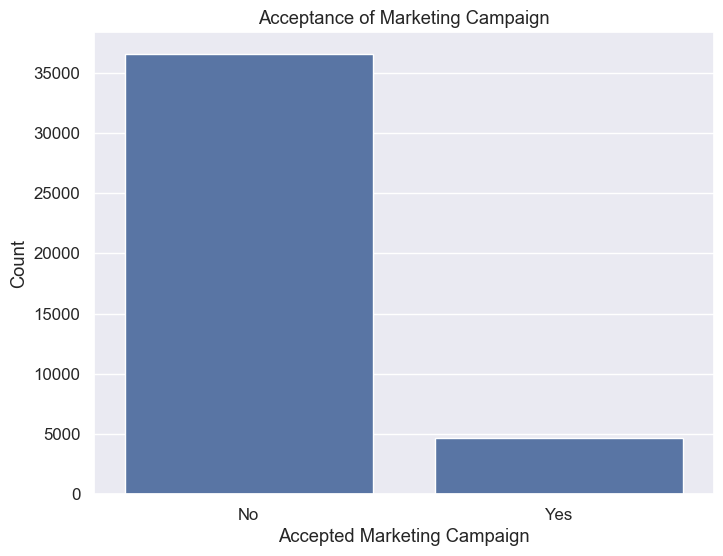

In [39]:
plt.subplots(figsize=(8,6))
splot = sns.countplot(data=df, x = 'y')
splot.set_xticklabels(['No', 'Yes'])
plt.xlabel('Accepted Marketing Campaign')
plt.ylabel('Count')
plt.title('Acceptance of Marketing Campaign')
plt.show()

In [40]:
# model executor
# it uses X_train, y_train and X_test, y_test sets automatically!
def model_executor(model, cv_cnt, params, scorer, jobs=1):
    model_grid = GridSearchCV(model, cv = cv_cnt, param_grid = params,
                              scoring = scorer, n_jobs = jobs).fit(X_train, y_train)
    model_train = model_grid.score(X_train, y_train)
    model_test = model_grid.score(X_test, y_test)
    model_time = np.mean(model_grid.cv_results_['mean_fit_time'])
    model_params = model_grid.best_params_
    model_results = model_grid.cv_results_

    # results
    print(f'Training Accuracy: {model_train: .5f}')
    print(f'Test Accuracy    : {model_test: .5f}')
    print(f'Average Fit Time : {model_time: .5f}')
    print(f'Best parameters @ {scorer} of {model}: {model_params}')

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_grid.predict(X_test), display_labels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

    return model_grid, model_train, model_test, model_time, model_params, model_results

In [41]:
# set scorer for GridSearchCV()
scorer = 'recall'

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [42]:
lgr = LogisticRegression()
cv_fold = 5

Training Accuracy:  0.00000
Test Accuracy    :  0.00000
Average Fit Time :  0.00880
Best parameters @ recall of LogisticRegression(): {'C': 1}


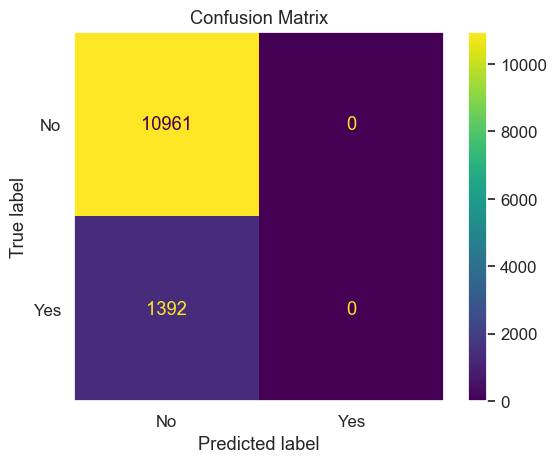

In [43]:
# Default hyperparameter values for LogisticRegression()
params = {'C':[1]}
lgr_grid, lgr_train, lgr_test, lgr_time, lgr_params, lgr_results = model_executor(lgr, cv_fold, params, scorer)

### Problem 9: Score the Model

What is the accuracy of your model?

In [44]:
print(f'Test Accuracy    : {lgr_test: .5f}')

Test Accuracy    :  0.00000


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [45]:
# Define models
knn = KNeighborsClassifier()
svc = SVC()
dtr = DecisionTreeClassifier()

Training Accuracy:  0.14075
Test Accuracy    :  0.06897
Average Fit Time :  0.02854
Best parameters @ recall of KNeighborsClassifier(): {'n_neighbors': 5, 'weights': 'uniform'}


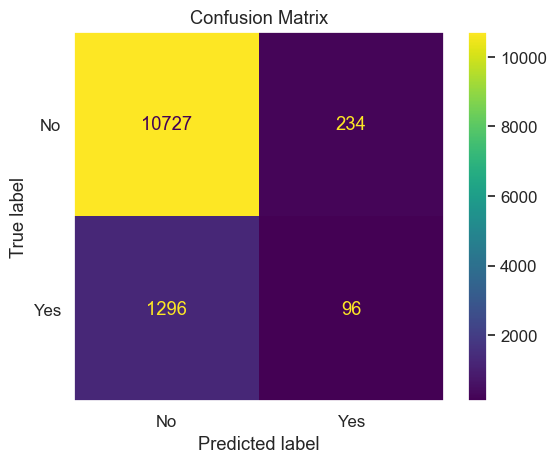

In [46]:
# KNN model
params = {'n_neighbors': [5], 'weights':['uniform']}
knn_grid, knn_train, knn_test, knn_time, knn_params, knn_results = model_executor(knn, cv_fold, params, scorer)

Training Accuracy:  0.00647
Test Accuracy    :  0.00503
Average Fit Time :  12.87198
Best parameters @ recall of SVC(): {'cache_size': 1000}


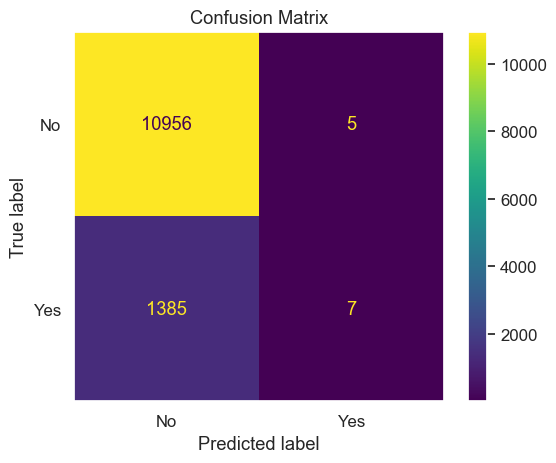

In [47]:
# SVM model
params = {'cache_size':[1000]}
svc_grid, svc_train, svc_test, svc_time, svc_params, svc_results = model_executor(svc, cv_fold, params, scorer, 4)

Training Accuracy:  0.29073
Test Accuracy    :  0.09626
Average Fit Time :  0.02929
Best parameters @ recall of DecisionTreeClassifier(): {'criterion': 'gini'}


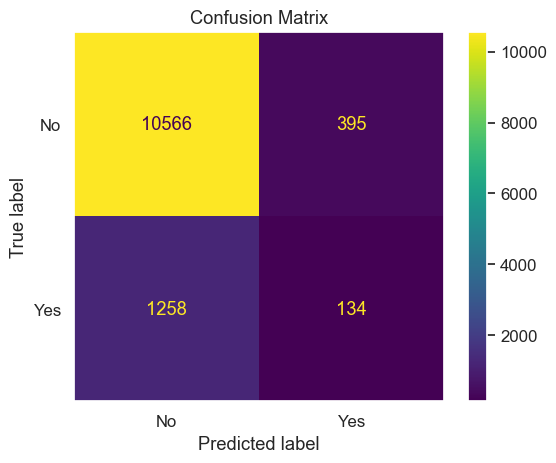

In [48]:
# Decision Tree model
params = {'criterion': ['gini']}
dtr_grid, dtr_train, dtr_test, dtr_time, dtr_params, dtr_results = model_executor(dtr, cv_fold, params, scorer)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [49]:
# Build a dataframe Model	Train Time	Train Accuracy	Test Accuracy
model_df1 = pd.DataFrame({'Model':['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
                          'Train Time':[lgr_time, knn_time, dtr_time, svc_time],
                          'Train Accuracy':[lgr_train, knn_train, dtr_train, svc_train],
                          'Test Accuracy':[lgr_test, knn_test, dtr_test, svc_test]
                         })
model_df1

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.008795,0.000000,0.000000
1,KNN,0.028543,0.140745,0.068966
2,Decision Tree,0.029287,0.290730,0.096264
3,SVM,12.871985,0.006468,0.005029


In [50]:
X, y = df.drop(['duration', 'pdays', 'previous', 'cons.price.idx', 'euribor3m', 'nr.employed', 'y'], axis=1), df.y
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0,56,0,0,2,1,1,1,0,5,1,1,0,1.1,-36.4
1,57,1,0,5,0,1,1,0,5,1,1,0,1.1,-36.4
2,37,1,0,5,1,2,1,0,5,1,1,0,1.1,-36.4
3,40,2,0,3,1,1,1,0,5,1,1,0,1.1,-36.4
4,56,1,0,5,1,1,2,0,5,1,1,0,1.1,-36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,0,6,1,2,1,1,11,5,1,0,-1.1,-50.8
41184,46,3,0,6,1,1,1,1,11,5,1,0,-1.1,-50.8
41185,56,5,0,7,1,2,1,1,11,5,2,0,-1.1,-50.8
41186,44,4,0,6,1,1,1,1,11,5,1,0,-1.1,-50.8


In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
# build a overlapped list
df1 = df.groupby(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx']).size().reset_index()
df1[df1[0]>1]

,age,job,marital,education,default,contact,month,campaign,poutcome,emp.var.rate,cons.conf.idx,0
2,17,11,1,4,1,1,8,2,1,-2.9,-31.4,2
8,18,11,1,0,1,1,5,1,2,-1.8,-40.0,2
11,18,11,1,0,1,1,9,1,0,-3.4,-29.8,2
23,18,11,1,4,1,1,12,2,0,-3.0,-33.0,2
34,19,11,1,0,1,1,4,3,0,-1.8,-47.1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29604,82,5,0,7,1,1,10,1,0,-3.4,-26.9,2
29606,82,5,1,2,1,1,10,2,0,-3.4,-26.9,2
29662,88,5,2,2,1,1,3,1,0,-1.8,-50.0,2
29663,88,5,2,2,1,1,3,2,0,-1.8,-50.0,2


In [53]:
# Find out how many data entries is in the overlapped category to see how good a model could be - These cannot be correctly classified
print('Overlapped Features Rate:', \
    len(df.merge(df1[df1[0]>1], on = ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'])) / len(df))
print('Overlapped Features Rows:', \
    len(df.merge(df1[df1[0]>1], on = ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'])))

Overlapped Features Rate: 0.08900816009325821
Overlapped Features Rows: 3665


In [54]:
#9% of full dataset cannot be correctly classified as the remaining features on it cannot distinctly define boundaries in the final outcome
#If we assume 50-50 distribution, the best outcome will be 95% but realiably accurate outcome is 91%.

In [55]:
# permutation importance
# function to execute permutation importance!
def column_importance(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, train_size=0.7, test_size=0.3)
    # fit model with training set
    ridge = Ridge(alpha = 0.0000001)
    model = ridge.fit(X_train, y_train)
    # score with test set
    print('model r^2 :', model.score(X_test, y_test))
    # permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats = 50, random_state = 93)
    print('importance:', r.importances_mean)
    return model, X_test, y_test, pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

In [56]:
# Variance Inflation Factor (VIF)
# multicollinearity any feature 5+
def vif(data):
    columns = data.columns
    vif_dict = {}

    for col in data.select_dtypes(include=np.number).columns:
        exclude_col = [i for i in columns if i != col]
        X,y = data[exclude_col], data[col]

        features = data.select_dtypes(exclude=np.number).columns
        features = [c for c in data.select_dtypes(exclude=np.number).columns if c in data.columns]
        ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough")
        # fit model with training set
        pipe = Pipeline([('transformer', ohe_step),
                         ('scaler', StandardScaler(with_mean=False)),
                         ('ridge', Ridge(alpha = 10)) ])
        # vif = 1 / (1- R^2)
        r_squared = pipe.fit(X, y).score(X, y)
        if r_squared == 1:
            vif = 0
        else:
            vif = 1 / (1-r_squared)
        vif_dict[col] = vif

    df_vif = pd.DataFrame({"VIF":vif_dict}).sort_values(by = "VIF", ascending = False)
    return df_vif

In [57]:
# Feature importance
model, Xp_test, yp_test, ranking = column_importance(X, y) #y.map({'no':0, 'yes':1}))
ranking

model r^2 : 0.12128358647614934
importance: [ 9.27777470e-04  1.25628222e-03  3.61076094e-04 -1.27753950e-04
  1.98839154e-03  2.41476612e-05  4.11840385e-06  5.34104554e-03
  5.79488815e-04 -1.94367962e-05  4.68954073e-04  4.77717745e-02
  9.30417767e-02  2.69133304e-02]


,Column,Importance
12,emp.var.rate,0.093042
11,poutcome,0.047772
13,cons.conf.idx,0.026913
7,contact,0.005341
4,default,0.001988
1,job,0.001256
0,age,0.000928
8,month,0.000579
10,campaign,0.000469
2,marital,0.000361


In [58]:
# Build a coefficient list
Cs = np.logspace(-5, .5)
coef_list = []
for Cval in Cs:
    lgr = LogisticRegression(penalty = 'l1', solver = 'liblinear',
                             C=Cval, random_state=93, max_iter = 1000).fit(X_scaled, y)
    coef_list.append(list(lgr.coef_[0]))
# coefficients
# coef_list[0]
# Build a dataframe
coef_df = pd.DataFrame(coef_list, columns=X.columns, index=Cs)
coef_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Check to see what is kept
selector = SelectFromModel(estimator=LogisticRegression(C = 0.01, penalty = 'l1', max_iter = 1000,
                                                        solver = 'liblinear', random_state = 93)).fit(X, y)
# top features by L1 regulation
print(selector.get_feature_names_out(X.columns))

['age' 'job' 'education' 'default' 'contact' 'month' 'campaign' 'poutcome'
 'emp.var.rate' 'cons.conf.idx']


In [60]:
#After  feature engineering has recealed the least impactful features we can remove them - loan, housing, and day_of_week. 
#Columns and split dataset again in to train and test since there is an agreement on those columns bc L1 regularization 

In [61]:
# print y before and after applying SMOTE
print(Counter(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(Counter(y))
# Scale new dataset
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Counter({0: 36537, 1: 4639})
Counter({0: 36537, 1: 36537})


In [62]:
# Remove loan and housing features
# use scaled dataset to split
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(['loan', 'housing', 'day_of_week'], axis=1), y,
                                                    random_state = 93, test_size = 0.3, stratify = y)

In [63]:
# Set scores to evaluate
scorings = ['roc_auc']
X_test.columns

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'],
      dtype='object')

Training Accuracy:  0.76140
Test Accuracy    :  0.76111
Average Fit Time :  0.02158
Best parameters @ roc_auc of LogisticRegression(): {'C': 1, 'max_iter': 500, 'solver': 'lbfgs'}


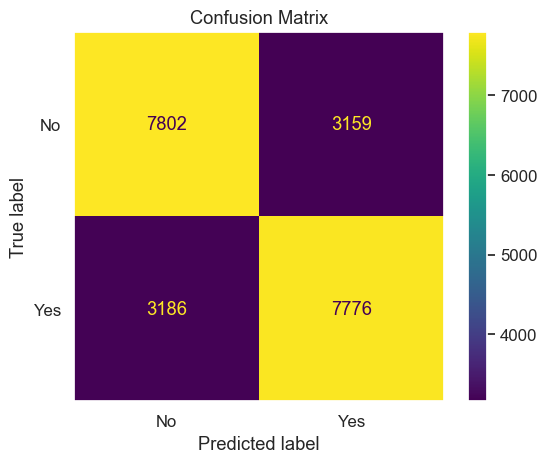

In [65]:
#Logistic Regression
# hyperparameter values for LogisticRegression()
lgr = LogisticRegression()
params = {'solver':['lbfgs', 'liblinear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':[500]}
#          'max_iter':[1000], 'class_weight':[{0:.87, 1:.13}]}
for scorer in scorings:
    lgr_grid, lgr_train, lgr_test, lgr_time, lgr_params, lgr_results = model_executor(lgr, cv_fold, params, scorer)

Training Accuracy:  0.99565
Test Accuracy    :  0.90747
Average Fit Time :  0.07248
Best parameters @ roc_auc of KNeighborsClassifier(): {'n_jobs': 5, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


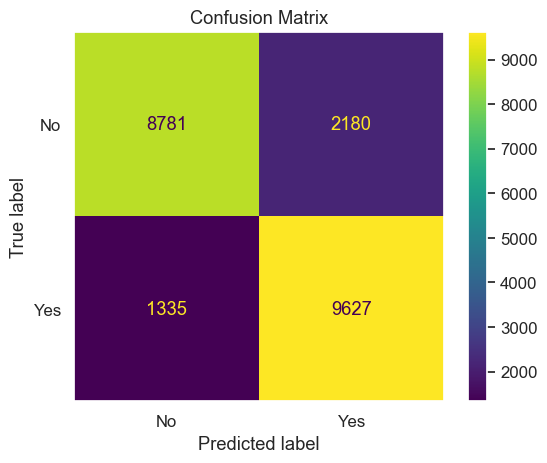

In [66]:
# KNN
# hyperparameter values
params = {'n_neighbors': range(3, 15, 2), 'weights':['uniform', 'distance'], 'p':[1, 2], 'n_jobs':[5]}
for scorer in scorings:
    knn_grid, knn_train, knn_test, knn_time, knn_params, knn_results = model_executor(knn, cv_fold, params, scorer)

Training Accuracy:  0.92710
Test Accuracy    :  0.88808
Average Fit Time :  0.06639
Best parameters @ roc_auc of DecisionTreeClassifier(): {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 0.001}


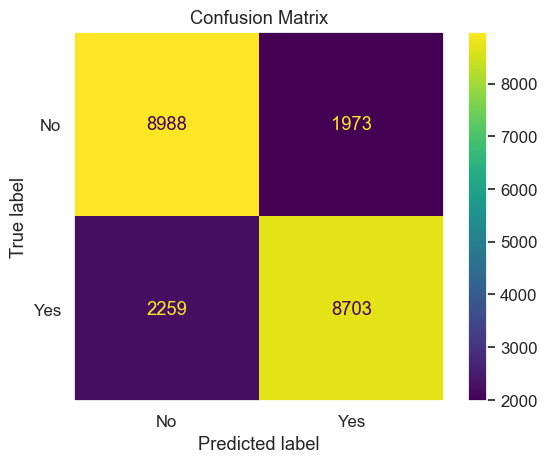

In [67]:
# Decision Tree
# hyperparameter values
params = {'max_depth': [5, 13, 23, 25, 27, 29, 30, 33, 34, 43],
          'min_samples_split': [0.00001, 0.0001, 0.001, 0.01],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [2]
         }
for scorer in scorings:
    dtr_grid, dtr_train, dtr_test, dtr_time, dtr_params, dtr_results = model_executor(dtr, cv_fold, params, scorer)

Training Accuracy:  0.74881
Test Accuracy    :  0.74886
Average Fit Time :  52.79537
Best parameters @ roc_auc of SVC(): {'C': 0.001, 'cache_size': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


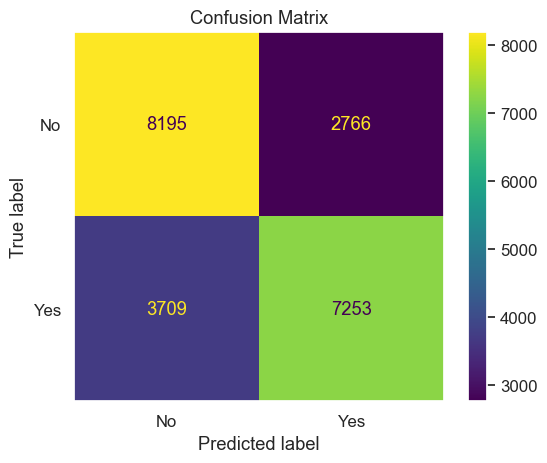

In [68]:
# SVM
# hyperparameter values - poly with degree=2?
params = {'kernel': ['rbf'], 'gamma': [0.001, 0.01],
          'C':[0.0001, 0.001], 'cache_size':[1000]}
for scorer in scorings:
    svc_grid, svc_train, svc_test, svc_time, svc_params, svc_results = model_executor(svc, cv_fold, params, scorer, 4)

In [69]:
tend = datetime.now()
print(tstart, '-', tend)
print(tend-tstart)

2025-02-04 15:52:51.998495 - 2025-02-04 16:21:15.354652
0:28:23.356157


In [70]:
# Build a dataframe Model for Train Time, Train Accuracy, and Test Accuracy
model_df2 = pd.DataFrame({'Model':['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
                          'Train Time':[lgr_time, knn_time, dtr_time, svc_time],
                          'Train Accuracy':[lgr_train, knn_train, dtr_train, svc_train],
                          'Test Accuracy':[lgr_test, knn_test, dtr_test, svc_test]
                         })
model_df2

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.021583,0.761401,0.761111
1,KNN,0.072482,0.995645,0.907467
2,Decision Tree,0.066393,0.927099,0.888075
3,SVM,52.795369,0.748811,0.748862


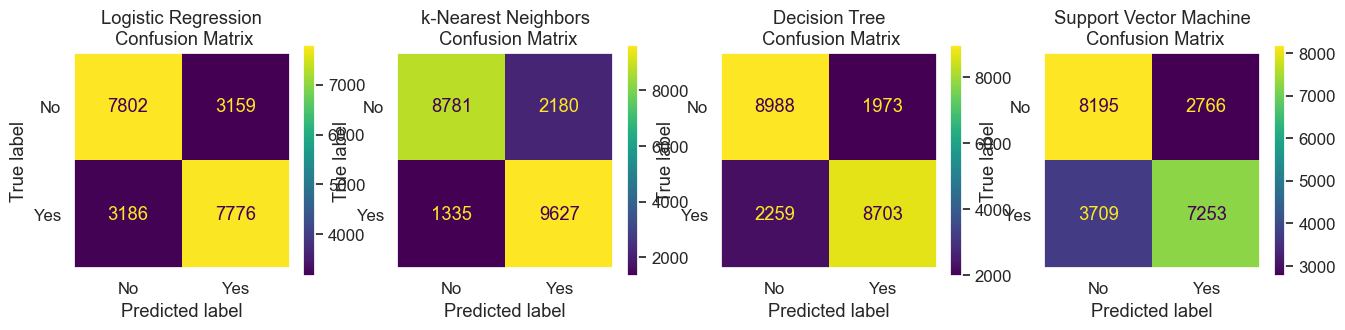

In [71]:
# plot confusion matrices as summary side-by-side
fig, ax = plt.subplots(1, 4, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, lgr_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, knn_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, dtr_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[2])
ConfusionMatrixDisplay.from_predictions(y_test, svc_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[3])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('k-Nearest Neighbors\n Confusion Matrix')
ax[2].set_title('Decision Tree\n Confusion Matrix')
ax[3].set_title('Support Vector Machine\n Confusion Matrix')
plt.show()

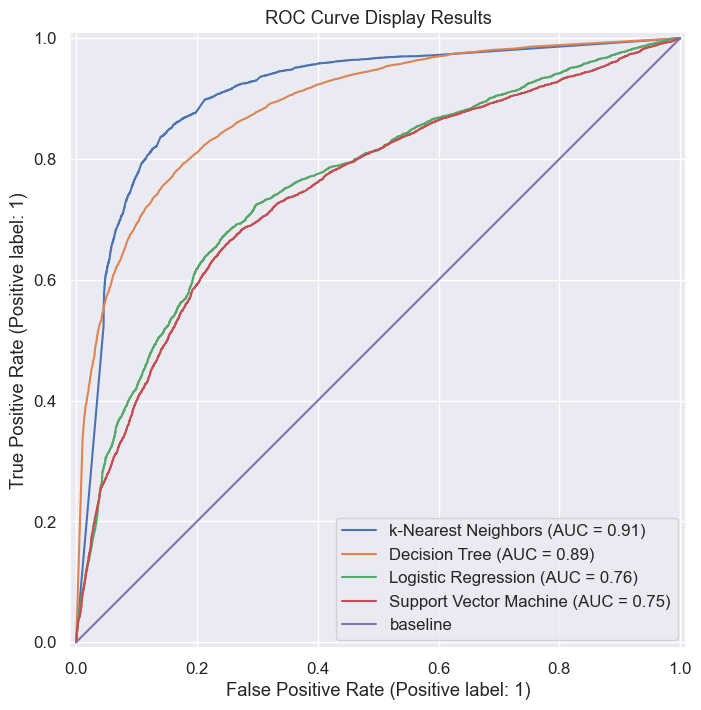

In [72]:
fig, ax = plt.subplots(figsize=(14,8))
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'k-Nearest Neighbors (AUC = 0.91)')
RocCurveDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Decision Tree (AUC = 0.89)')
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Logistic Regression (AUC = 0.76)')
RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Support Vector Machine (AUC = 0.75)')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('ROC Curve Display Results')
plt.legend()
plt.grid(True)

##### Questions